This is the notebook where we conduct trials on SNR and Unmixing...

The list goes as: 

1- RMSE Unmixing,
2- Derivative Unmixing,
3- KL-Div Unmixing

In [150]:
# Imports go here

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(r"C:/SenkDosya/UTAT/Github/FINCH-Science") # Add path for the Unmixing_Methods folder, the string is different for you probably

SNR_options = [100,120,140,160,180,200,220,240,260,280]

for i in SNR_options:
    globals()[f'library_SNR_{i}'] = pd.read_csv(rf"C:\SenkDosya\UTAT\Data\General_Data\Noised_Data\simpler_data_SNR_{i}.csv")

    # Extract abundances and values from the dataframes
    globals()[f'abundances_library_SNR_{i}'] = (globals()[f'library_SNR_{i}'].iloc[:, 1:4]).to_numpy()
    globals()[f'values_library_SNR_{i}'] = (globals()[f'library_SNR_{i}'].iloc[:, 115:131]).to_numpy()

emlibrary = pd.read_csv(r"C:\SenkDosya\UTAT\Data\General_Data\simpler_data_rwc.csv")
values_emlibrary = (emlibrary.iloc[:, 117:133]).to_numpy()

# Pick your endmember indices here:
em_indices = [117,76,1387]
values_emlibrary = values_emlibrary[em_indices, :]

In [ ]:
# Here, we do unmixing using RMSE method. We first have to import the RMSE function, if you use a GitHub version, this works fine but if you use a local version, you may need to change the path accordignly.

from Unmixing_Methods.Conventional_Unmixing_Methods.SOO_RMSE import SOO_RMSE

# We now unmix on data with different SNR values using the RMSE method.

for i in SNR_options:
    globals()[f'abundances_RMSE_SNR_{i}'],_,_ = SOO_RMSE(pd.DataFrame(globals()[f'values_library_SNR_{i}']), pd.DataFrame(values_emlibrary), plot_results=False)
    
    if i == SNR_options[-1]:
        print("Abundances calculated for all SNRs using Spectral RMSE.")



Abundances calculated for all SNRs using Spectral RMSE.


In [ ]:
# Here, we do the unmixing using the Derivative method. We first have to import the Derivative function, if you use a GitHub version, this works fine but if you use a local version, you may need to change the path accordingly.

# Could not import this for now

def dataframe_derivative(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ 
    Return DataFrame of the numerical derivation of the contents in each row of all its associated wavelengths
    in each column using np.gradient function.
    """
    dataframe_array = dataframe.values
    dataframe_derivative_array = np.gradient(dataframe_array, axis=1) # Axis=1 means taking deriv across columns
    dataframe_derivative = pd.DataFrame(dataframe_derivative_array, dataframe.index, dataframe.columns)

    return dataframe_derivative

for i in SNR_options:
    globals()[f'values_library_Derivative_SNR_{i}'] = dataframe_derivative(pd.DataFrame(globals()[f'values_library_SNR_{i}']))* 100000

    if i == SNR_options[-1]:
        print("Derivative values calculated for all SNRs.")

values_emlibrary_derivative = dataframe_derivative(pd.DataFrame(values_emlibrary)) * 100000

for i in SNR_options:
    globals()[f'abundances_Derivative_SNR_{i}'],_,_ = SOO_RMSE(pd.DataFrame(globals()[f'values_library_Derivative_SNR_{i}']), pd.DataFrame(values_emlibrary_derivative), plot_results=False)

    if i == SNR_options[-1]:
        print("Abundances calculated for all SNRs using Derivative RMSE.")


Derivative values calculated for all SNRs.


In [156]:
# Here, we do the unmixing using the KL Divergence method. We first have to import the KL Divergence function, if you use a GitHub version, this works fine but if you use a local version, you may need to change the path accordingly.

from Unmixing_Methods.Unconventional_Unmixing_Methods.KLDiv import kl_divergence_unmixing

for i in SNR_options:
    globals()[f'abundances_KLDiv_SNR_{i}'] = np.zeros(shape=((globals()[f'values_library_SNR_{i}']).shape[0], 3))

    for j in range(globals()[f'values_library_SNR_{i}'].shape[0]):
        (globals()[f'abundances_KLDiv_SNR_{i}'])[j] = kl_divergence_unmixing(globals()[f'values_library_SNR_{i}'][j,:], values_emlibrary,False)

    if i == SNR_options[-1]:
        print("Abundances calculated for all SNRs using KL-Div.")


Abundances calculated for all SNRs using KL-Div.


In [157]:
# Now, we plot results, do some analysis... We start by defining functions for plotting the results.

from scipy.stats import linregress

def plot_abundance_comparison(true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame, title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = False):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    """

    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    darkened_colors = ['darkgreen', 'darkblue', 'saddlebrown']
    # Create a scatter plot for each column (abundance type)

    fig, ax = plt.subplots(figsize=(8, 6))

    for column in optimized_ab_df.columns:
        ax.scatter(true_ab_df[column], optimized_ab_df[column], label=types[column], color=colors[column])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        for column in optimized_ab_df.columns:
            # Calculate the best fit line
            slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[column], optimized_ab_df[column])
            r_value = r_value **2
            print(f"Best fit line for {types[column]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}")
            ax.plot(true_ab_df[column], slope * (true_ab_df[column]) + intercept, color=darkened_colors[column], linestyle='--', label=f'Best Fit {types[column]}')
    
    ax.set_ylabel('Optimized Abundance')
    ax.set_xlabel('True Abundance')
    ax.set_title(title)

    plt.show()

def plot3_abundance_comparison(ax, true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame,title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = False):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    
    Note: if using multiplot, ax should be passed as an argument, otherwise it will create a new figure and axis.
    And fig, ax = plt.subplots(1, 3, figsize=(15, 5)) must be used to create the subplots.
    """

    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    darkened_colors = ['darkgreen', 'darkblue', 'saddlebrown']
    
    for column in optimized_ab_df.columns:
        ax.scatter(true_ab_df[column], optimized_ab_df[column], label=types[column], color=colors[column])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        for column in optimized_ab_df.columns:
            
            # Calculate the best fit line
            slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[column], optimized_ab_df[column])
            r_value = r_value **2
            print(f"Best fit line for {types[column]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}")
            ax.plot(true_ab_df[column], slope * (true_ab_df[column]) + intercept, color=darkened_colors[column], linestyle='--', label=f'Best Fit {types[column]}')
    
    ax.set_ylabel('Optimized Abundance')
    ax.set_xlabel('True Abundance')
    ax.set_title(title)

def plot_single_abundance_comparison(abundance_type: int, true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame, title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = True):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    """

    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    
    # Create a scatter plot for each column (abundance type)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(optimized_ab_df[abundance_type], true_ab_df[abundance_type], label=types[abundance_type], color=colors[abundance_type])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        # Calculate the best fit line
        slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[abundance_type], optimized_ab_df[abundance_type])
        r_value = r_value **2
        print(f"Best fit line for {types[abundance_type]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}") 
        ax.plot(true_ab_df[abundance_type], slope * (true_ab_df[abundance_type]) + intercept, color='magenta', linestyle='--', label=f'Best Fit {types[abundance_type]}')

        return slope, intercept, r_value, p_value, std_err

    
    ax.set_xlabel('Optimized Abundance')
    ax.set_ylabel('True Abundance')
    ax.set_title(title)

    plt.show()

def plot3_single_abundance_comparison(ax, abundance_type: int, true_ab_df: pd.DataFrame, optimized_ab_df: pd.DataFrame, title: str = "Abundance Comparison", goalline: bool = True, best_fit: bool = True):
    """
    Creates a scatter plot comparing optimized abundance (y-axis) with true abundances (x-axis).
    """
    types = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    colors = ['green', 'blue', 'brown']
    
    ax.scatter(optimized_ab_df[abundance_type], true_ab_df[abundance_type], label=types[abundance_type], color=colors[abundance_type])

    if goalline:
        # Add a y=x line for the goal
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Goal Line (y=x)')

    if best_fit:
        # Calculate the best fit line
        slope, intercept, r_value, p_value, std_err = linregress(true_ab_df[abundance_type], optimized_ab_df[abundance_type])
        r_value = r_value **2

        print(f"Best fit line for {types[abundance_type]}: slope = {slope}, intercept = {intercept}, r^2 = {r_value**2}") 
        ax.plot(true_ab_df[abundance_type], slope * (true_ab_df[abundance_type]) + intercept, color='magenta', linestyle='--', label=f'Best Fit {types[abundance_type]}')

        return slope, intercept, r_value, p_value, std_err
    
    ax.set_ylabel('Optimized Abundance')
    ax.set_xlabel('True Abundance')
    ax.set_title(title)
    

Best fit line for gv_fraction: slope = 0.9282489085236736, intercept = 0.2195435674898733, r^2 = 0.34001564438903614
Best fit line for gv_fraction: slope = 0.38436554730006867, intercept = 0.29510430771725404, r^2 = 0.03328165891424135
Best fit line for gv_fraction: slope = 0.9290512981754705, intercept = -0.012916917343246459, r^2 = 0.5408509081528663


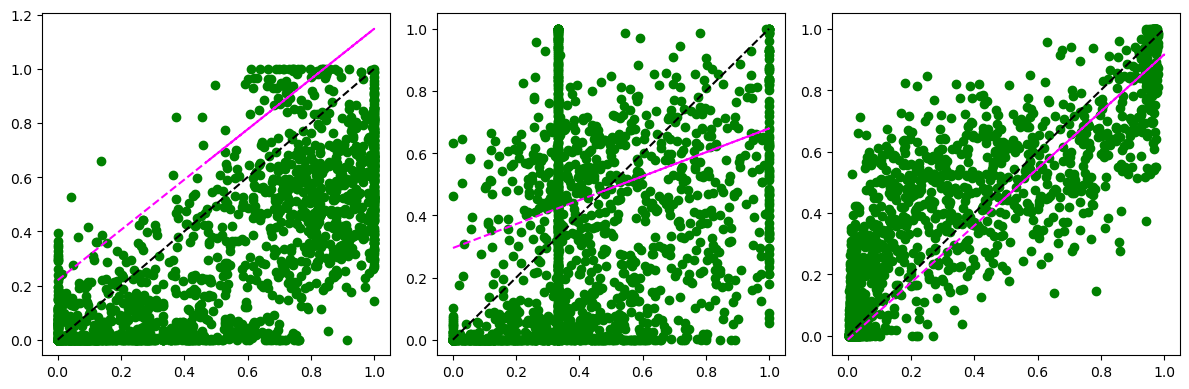

Best fit line for npv_fraction: slope = 0.173615857193297, intercept = 0.201775498789518, r^2 = 0.0009220795222980118
Best fit line for npv_fraction: slope = 0.36418126468875245, intercept = 0.09689822279303523, r^2 = 0.04497060748589883
Best fit line for npv_fraction: slope = 0.5314024713376355, intercept = 0.23498589016254087, r^2 = 0.09616213153630704


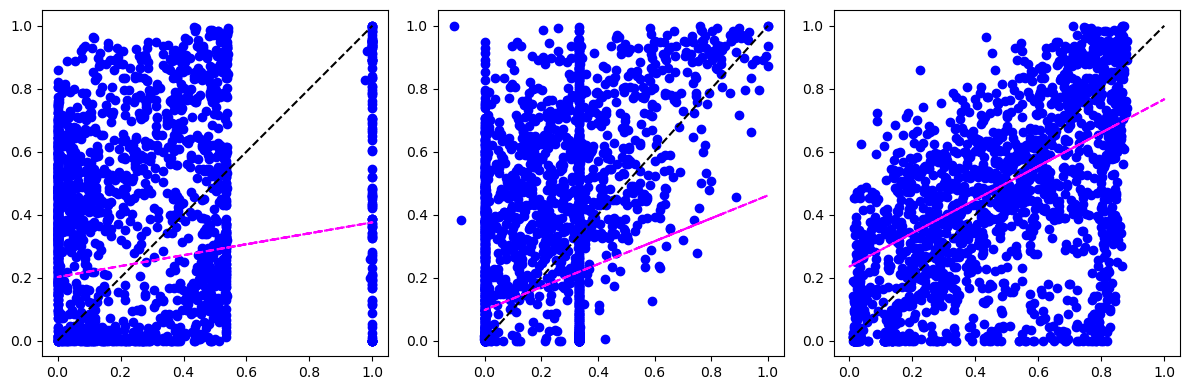

Best fit line for soil_fraction: slope = 0.22400356429937834, intercept = 0.159850038375934, r^2 = 0.04706696702948876
Best fit line for soil_fraction: slope = 0.357141474487254, intercept = 0.23940648405259554, r^2 = 0.07503173497435116
Best fit line for soil_fraction: slope = 0.4750246997750703, intercept = 0.13857322965381697, r^2 = 0.2785699803350145


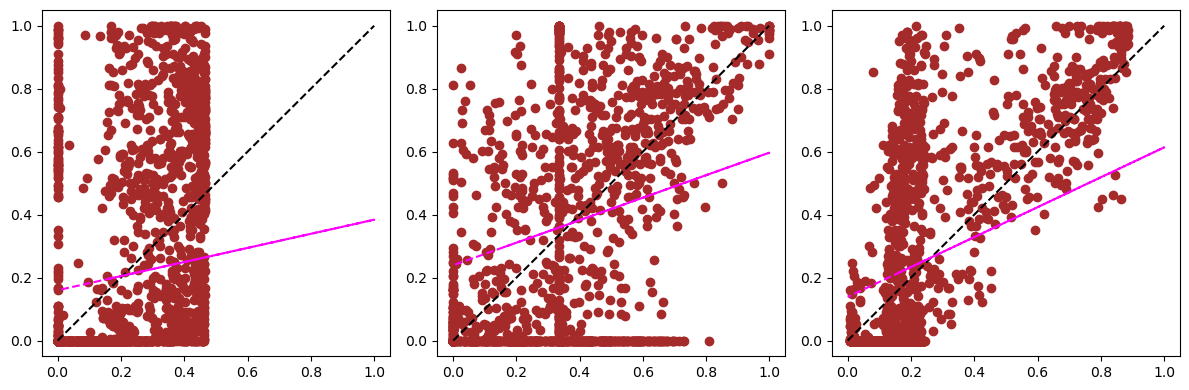

Best fit line for gv_fraction: slope = 0.9280618301898441, intercept = 0.21971049872215315, r^2 = 0.33994933351303996
Best fit line for gv_fraction: slope = 0.3906953407433498, intercept = 0.2949382199618348, r^2 = 0.03378522241080918
Best fit line for gv_fraction: slope = 0.9376612374559223, intercept = -0.013523624095217401, r^2 = 0.5414302217864794


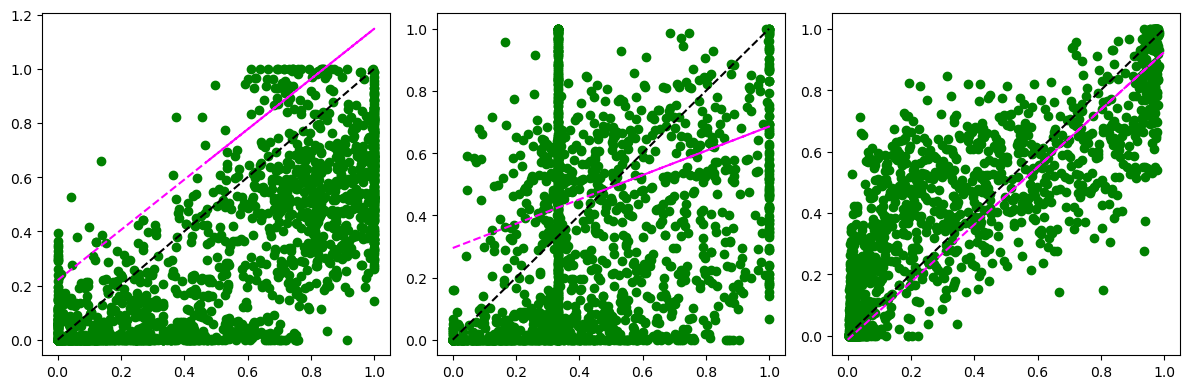

Best fit line for npv_fraction: slope = 0.17335568534366697, intercept = 0.20103450138832485, r^2 = 0.0009354280211156405
Best fit line for npv_fraction: slope = 0.39167950286237607, intercept = 0.07941402520137153, r^2 = 0.05909642057592843
Best fit line for npv_fraction: slope = 0.5366730250878167, intercept = 0.23238642479674568, r^2 = 0.09591990811401066


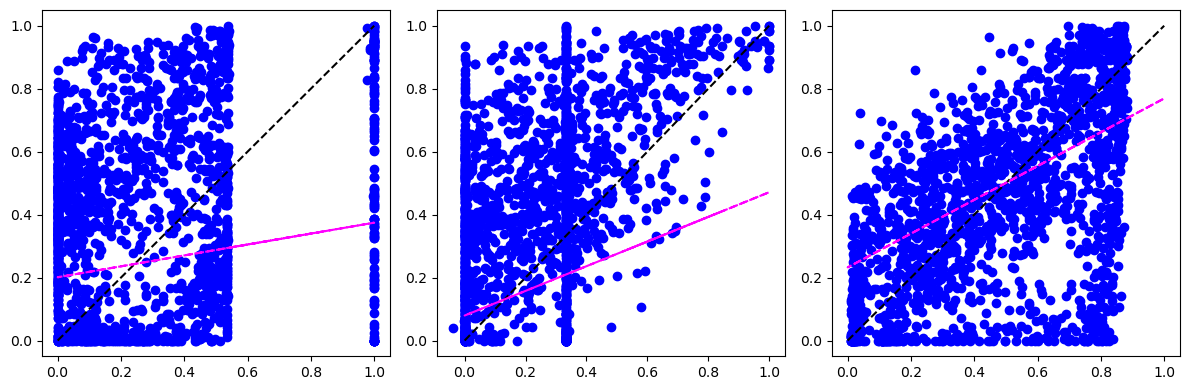

Best fit line for soil_fraction: slope = 0.2260645231721218, intercept = 0.16006670802283166, r^2 = 0.048723533587790975
Best fit line for soil_fraction: slope = 0.3702566305150334, intercept = 0.2397620547732442, r^2 = 0.08288842112857861
Best fit line for soil_fraction: slope = 0.4775472374966973, intercept = 0.13618538635742888, r^2 = 0.2776355312958269


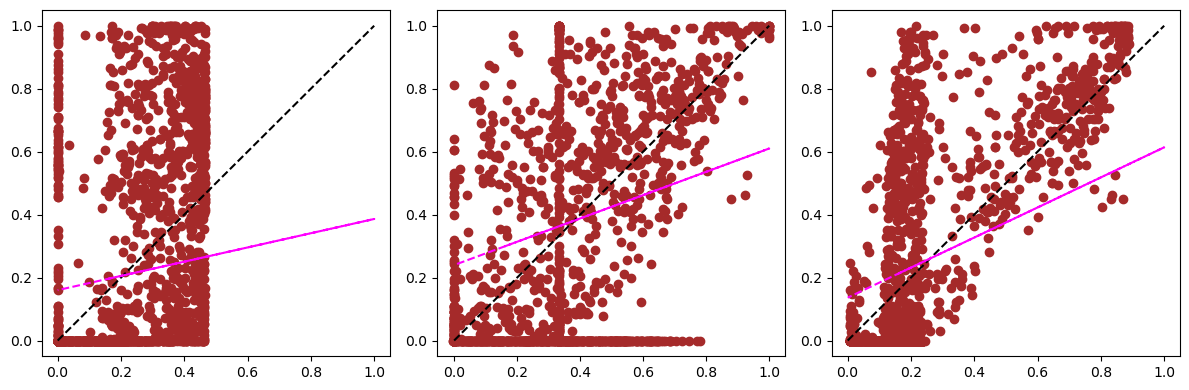

Best fit line for gv_fraction: slope = 0.9280509072837849, intercept = 0.21964714074845704, r^2 = 0.33994387209632737
Best fit line for gv_fraction: slope = 0.3844714001577512, intercept = 0.30127131722602335, r^2 = 0.03206111584345544
Best fit line for gv_fraction: slope = 0.9380400041397369, intercept = -0.013748771946443805, r^2 = 0.5393004120694376


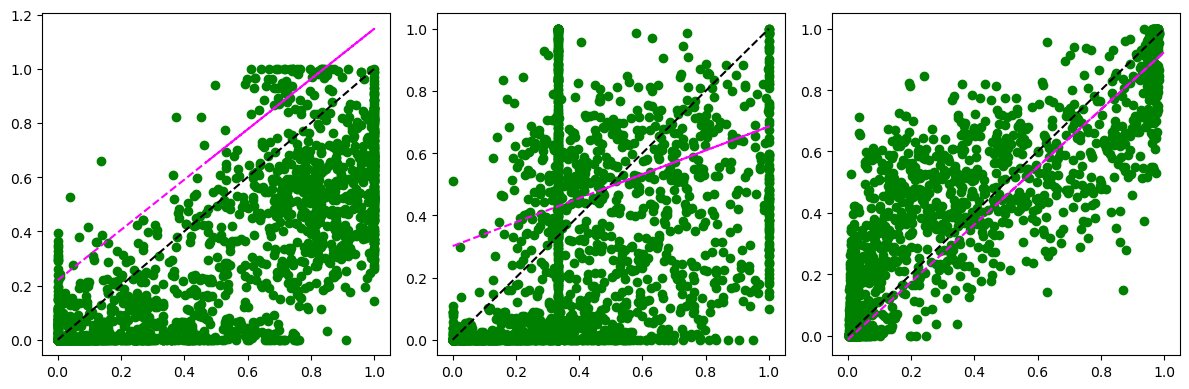

Best fit line for npv_fraction: slope = 0.1738734950033708, intercept = 0.20163501561345787, r^2 = 0.0009277184963099048
Best fit line for npv_fraction: slope = 0.3776068420035622, intercept = 0.07964579335748165, r^2 = 0.05627042962767503
Best fit line for npv_fraction: slope = 0.5429163392089243, intercept = 0.22996371641146898, r^2 = 0.09789528386729832


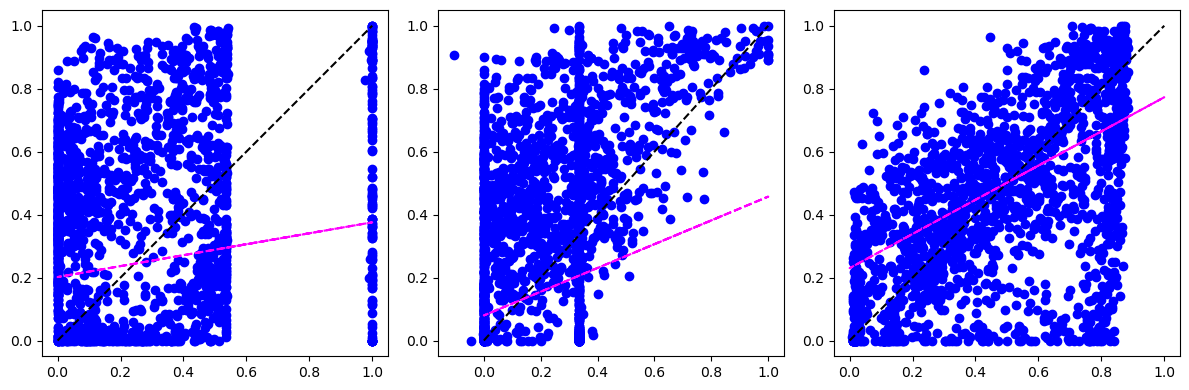

Best fit line for soil_fraction: slope = 0.22386104457787093, intercept = 0.1598721561928021, r^2 = 0.04698526350255575
Best fit line for soil_fraction: slope = 0.38714906688047535, intercept = 0.23691531643479632, r^2 = 0.09155263195982637
Best fit line for soil_fraction: slope = 0.482020481118436, intercept = 0.1348489675738815, r^2 = 0.27791386570481297


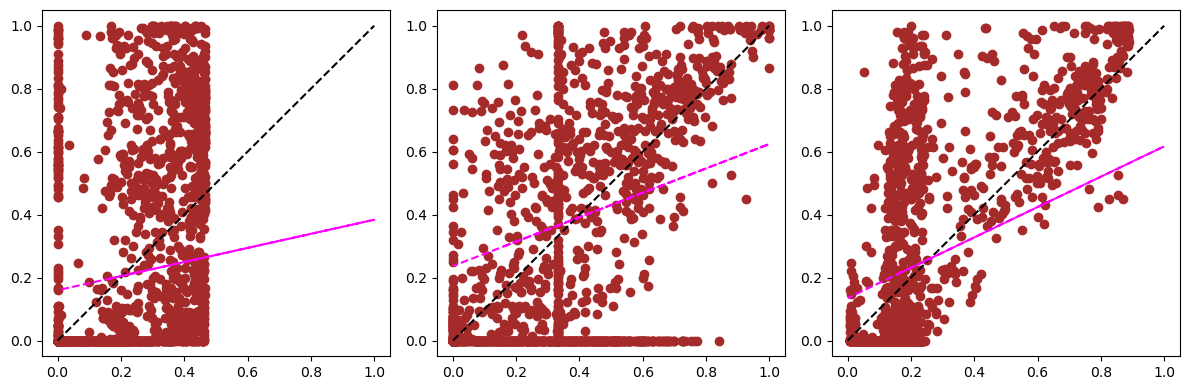

Best fit line for gv_fraction: slope = 0.9280387393616811, intercept = 0.21971664135632124, r^2 = 0.3398597577708175
Best fit line for gv_fraction: slope = 0.3787453610579941, intercept = 0.2943043670745969, r^2 = 0.03262268292061725
Best fit line for gv_fraction: slope = 0.9404423307049783, intercept = -0.01396973800463408, r^2 = 0.5386443135565799


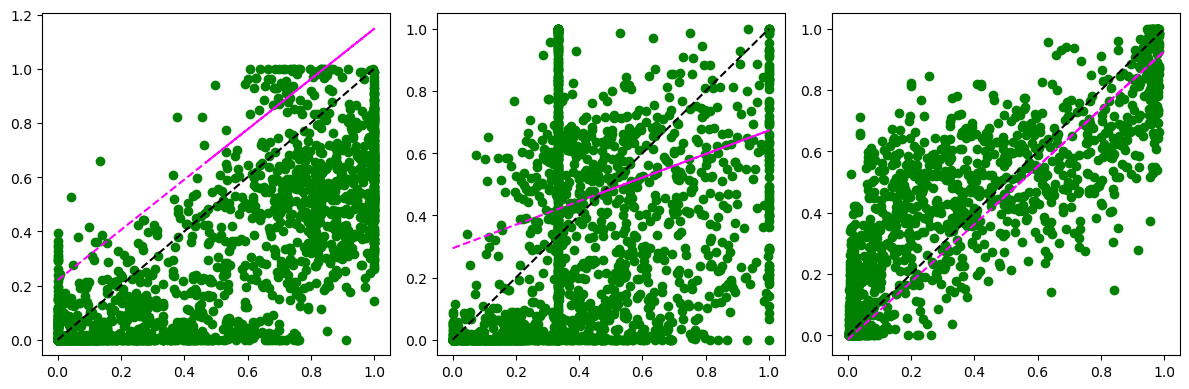

Best fit line for npv_fraction: slope = 0.17464988045080124, intercept = 0.20099761198458388, r^2 = 0.0009508080182554021
Best fit line for npv_fraction: slope = 0.40613108471629805, intercept = 0.07746235519661249, r^2 = 0.07866182390086136
Best fit line for npv_fraction: slope = 0.5408068439312483, intercept = 0.2309124855633987, r^2 = 0.09488678509589163


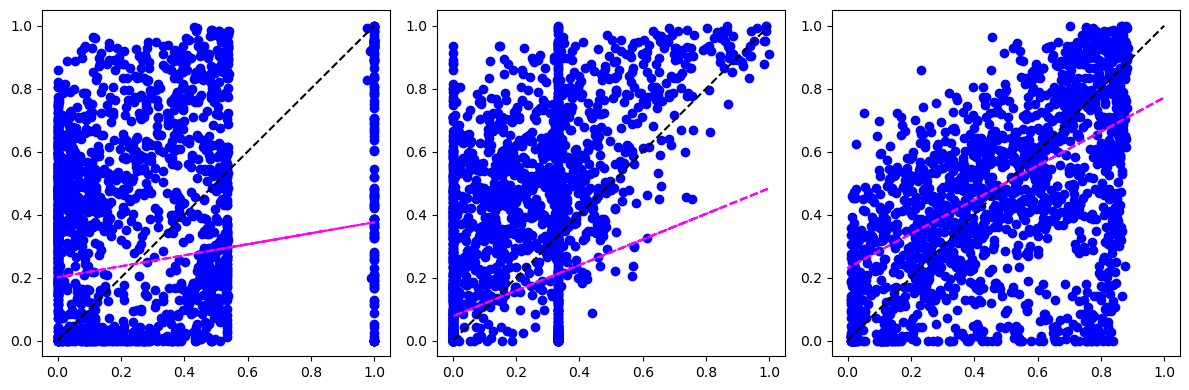

Best fit line for soil_fraction: slope = 0.22529774276567663, intercept = 0.15973712463140805, r^2 = 0.048151252195896735
Best fit line for soil_fraction: slope = 0.3715914990877947, intercept = 0.2393857998673989, r^2 = 0.08365501086997784
Best fit line for soil_fraction: slope = 0.4817140804550926, intercept = 0.1343795457742159, r^2 = 0.27403676006793604


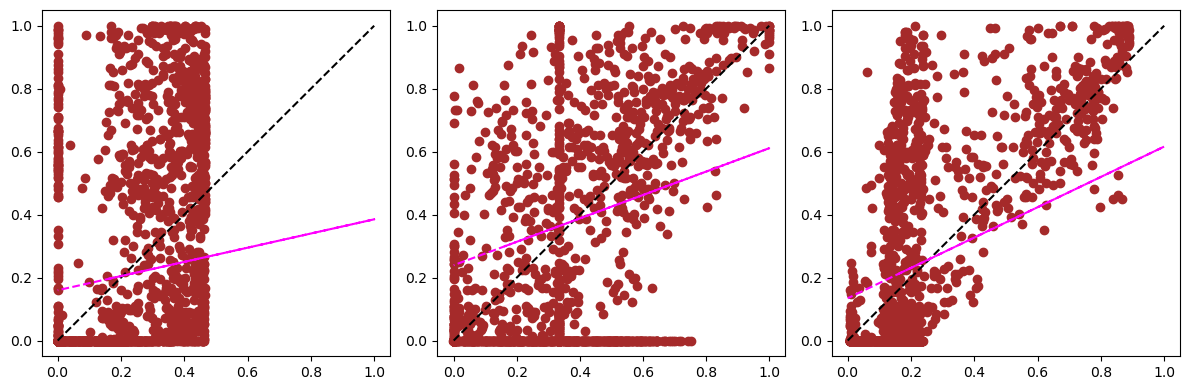

Best fit line for gv_fraction: slope = 0.9278811947655093, intercept = 0.2197053955146015, r^2 = 0.3397602264148695
Best fit line for gv_fraction: slope = 0.3912567267348847, intercept = 0.2953040930424462, r^2 = 0.034706333351179175
Best fit line for gv_fraction: slope = 0.9405276612753078, intercept = -0.014522614341310802, r^2 = 0.5376761652663818


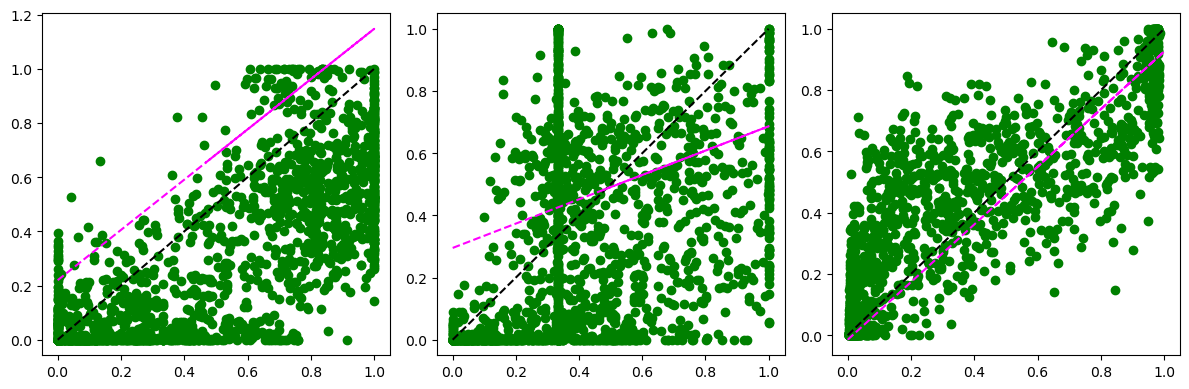

Best fit line for npv_fraction: slope = 0.17676480265288963, intercept = 0.2000981005616998, r^2 = 0.0009985710101082725
Best fit line for npv_fraction: slope = 0.40851100523660483, intercept = 0.07224768049048347, r^2 = 0.07969535221582925
Best fit line for npv_fraction: slope = 0.5445726315622076, intercept = 0.2304248233327661, r^2 = 0.0968511549227577


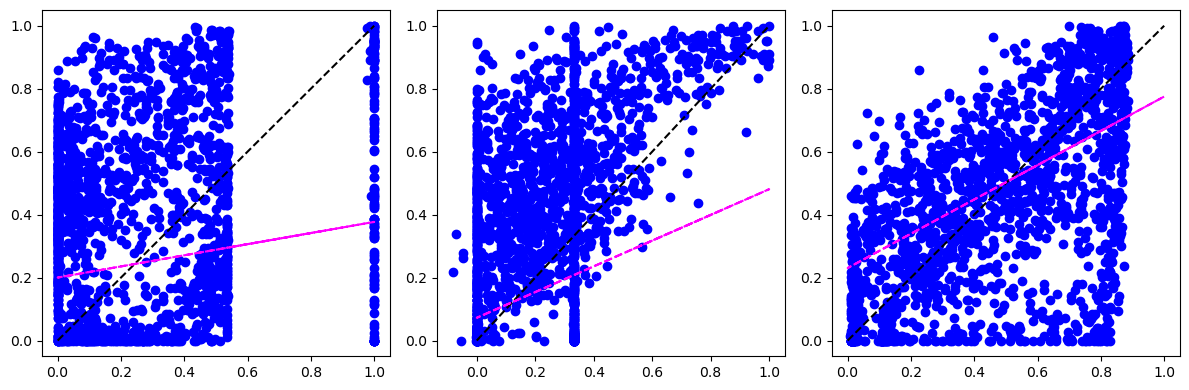

Best fit line for soil_fraction: slope = 0.22686181861099777, intercept = 0.15937370008654528, r^2 = 0.04953305355422892
Best fit line for soil_fraction: slope = 0.36630540022774805, intercept = 0.24006742627056743, r^2 = 0.08045148963504947
Best fit line for soil_fraction: slope = 0.48120702984521135, intercept = 0.13388265743020414, r^2 = 0.27409309938509013


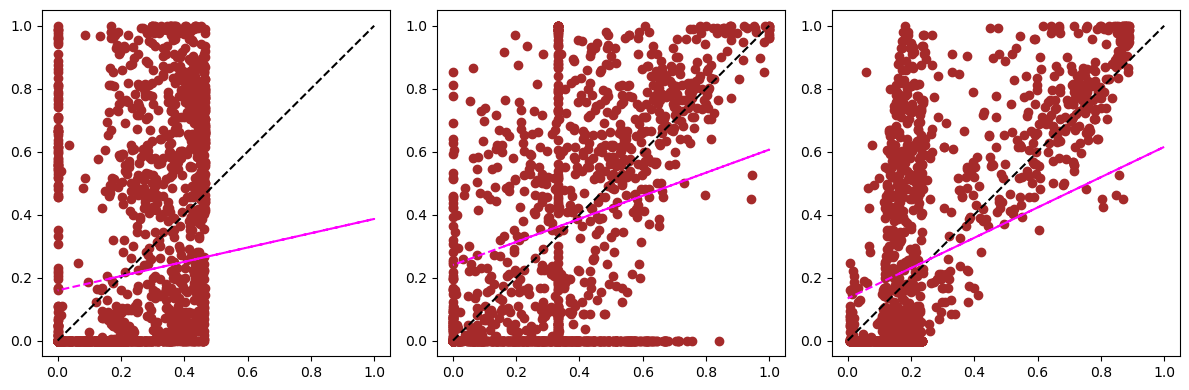

Best fit line for gv_fraction: slope = 0.9280599507820693, intercept = 0.21964259459281266, r^2 = 0.33991235557030014
Best fit line for gv_fraction: slope = 0.4040928052440363, intercept = 0.2876265553751013, r^2 = 0.04055961951530913
Best fit line for gv_fraction: slope = 0.9414701783189988, intercept = -0.014214658837189642, r^2 = 0.539661832526198


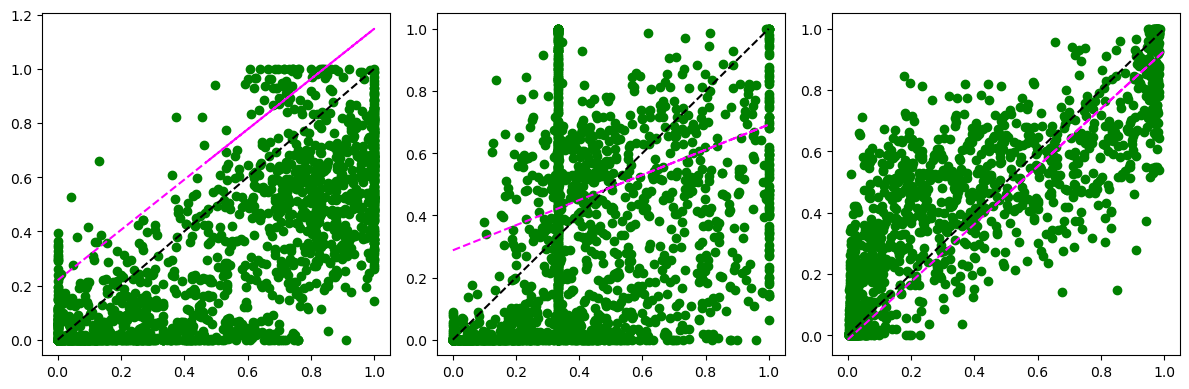

Best fit line for npv_fraction: slope = 0.17455308443634457, intercept = 0.20109021527826934, r^2 = 0.0009486363680975004
Best fit line for npv_fraction: slope = 0.41695528410064353, intercept = 0.06391394567138015, r^2 = 0.09338518589483583
Best fit line for npv_fraction: slope = 0.5441477396704928, intercept = 0.2298205157601891, r^2 = 0.09647554590757307


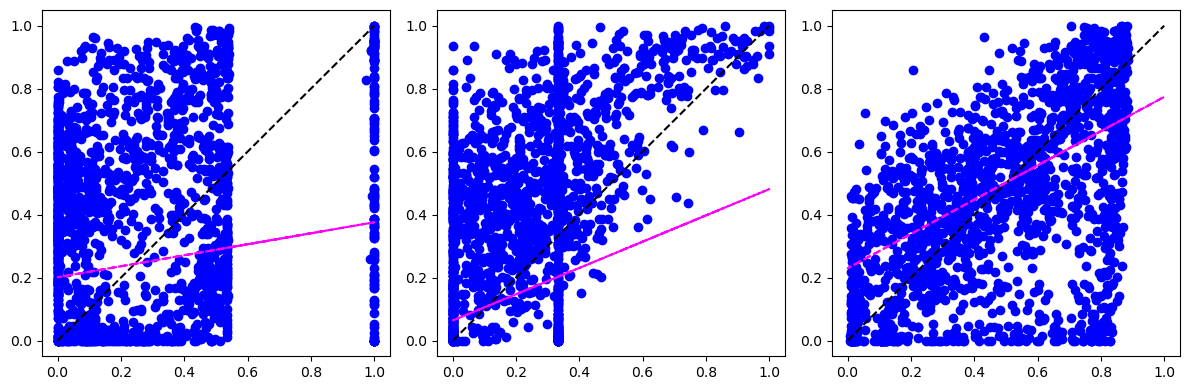

Best fit line for soil_fraction: slope = 0.22520879780409625, intercept = 0.1597770257785571, r^2 = 0.048081985629104776
Best fit line for soil_fraction: slope = 0.3958406996681137, intercept = 0.24087536363243017, r^2 = 0.10042326805816912
Best fit line for soil_fraction: slope = 0.48268495493105223, intercept = 0.13369515141354005, r^2 = 0.2748522375237778


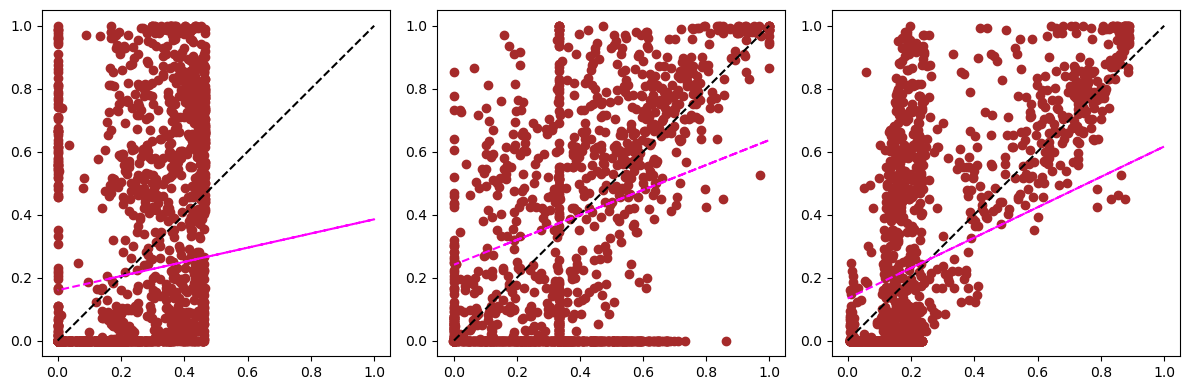

Best fit line for gv_fraction: slope = 0.9281284396718148, intercept = 0.21958921797527647, r^2 = 0.33998498601636173
Best fit line for gv_fraction: slope = 0.42368199157782865, intercept = 0.2899149845942357, r^2 = 0.0468169962846028
Best fit line for gv_fraction: slope = 0.941989147220543, intercept = -0.014744137922361844, r^2 = 0.5384559385285281


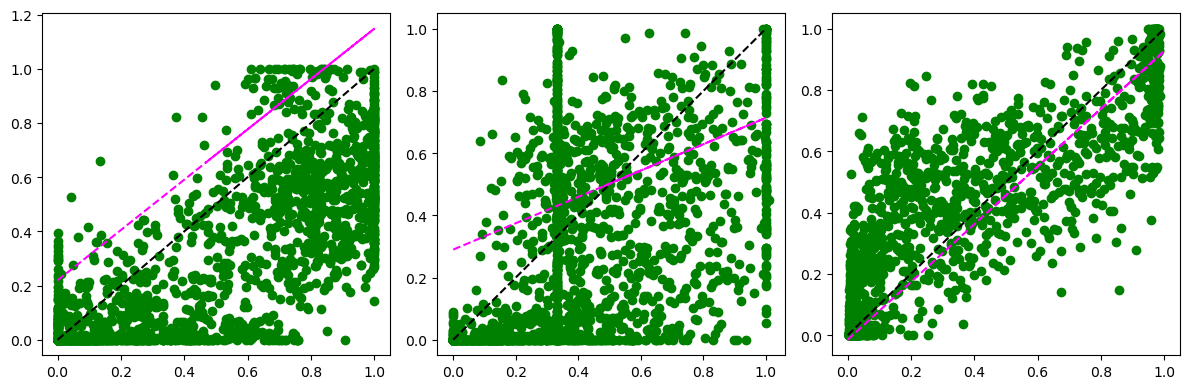

Best fit line for npv_fraction: slope = 0.17445826519633115, intercept = 0.20113301274734707, r^2 = 0.0009465616545960324
Best fit line for npv_fraction: slope = 0.41376569254951867, intercept = 0.06928190684601326, r^2 = 0.08646337660180221
Best fit line for npv_fraction: slope = 0.5458620551002504, intercept = 0.22962324697318098, r^2 = 0.09681910701087604


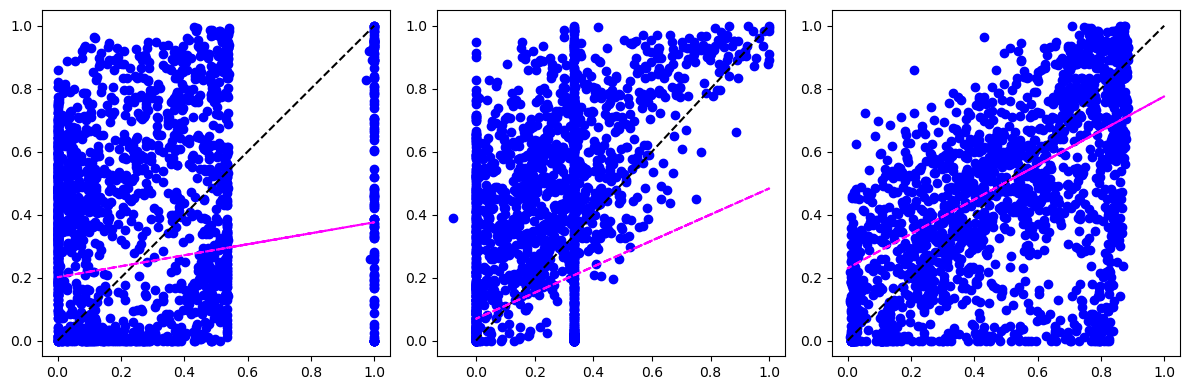

Best fit line for soil_fraction: slope = 0.22522034320299172, intercept = 0.1598048850775558, r^2 = 0.048103156841066495
Best fit line for soil_fraction: slope = 0.3714188041393064, intercept = 0.23483998290742603, r^2 = 0.08259713257361016
Best fit line for soil_fraction: slope = 0.48341698342969, intercept = 0.13332736734006095, r^2 = 0.2747470605508126


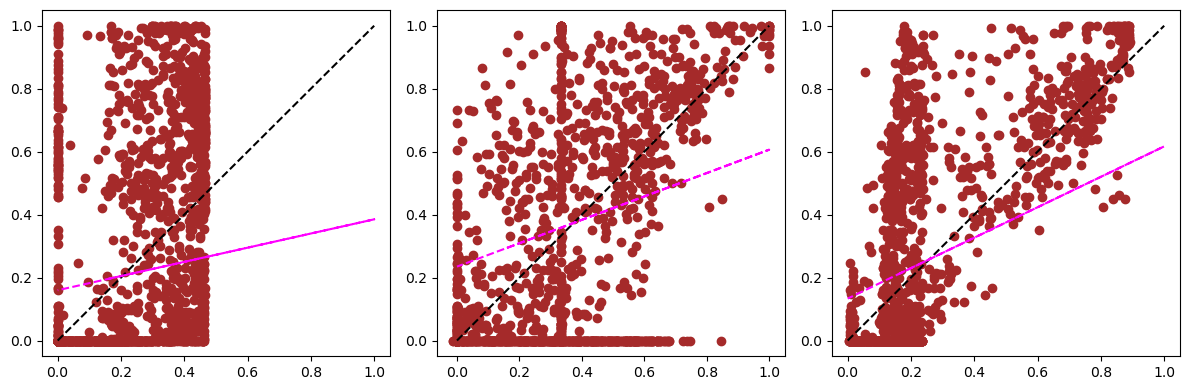

Best fit line for gv_fraction: slope = 0.9280171443329209, intercept = 0.21966351249669192, r^2 = 0.33992092000868107
Best fit line for gv_fraction: slope = 0.4321791462095022, intercept = 0.28408040875906454, r^2 = 0.0518691493227376
Best fit line for gv_fraction: slope = 0.9431635863639907, intercept = -0.014553815497013345, r^2 = 0.5383219217554366


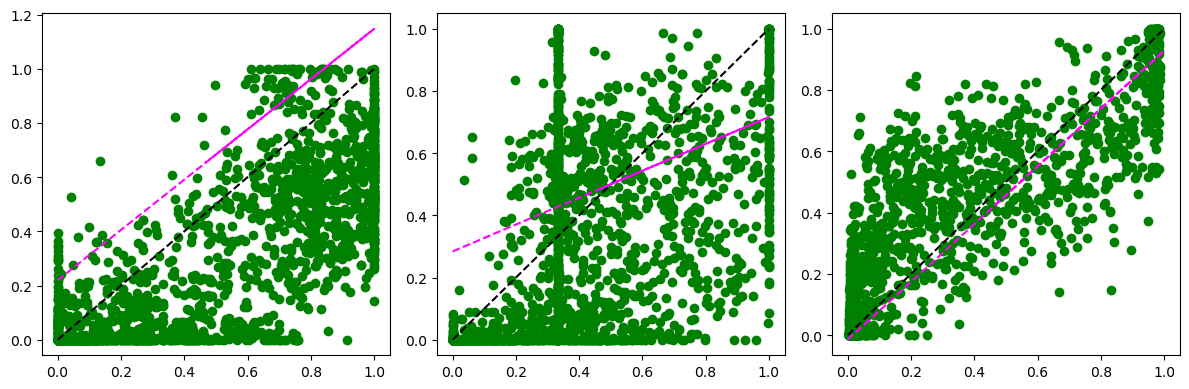

Best fit line for npv_fraction: slope = 0.17067747380167045, intercept = 0.2024949058575553, r^2 = 0.0008730389835150289
Best fit line for npv_fraction: slope = 0.4144609037080528, intercept = 0.06684070665018096, r^2 = 0.08948530558937894
Best fit line for npv_fraction: slope = 0.5457027370015693, intercept = 0.22957351943693663, r^2 = 0.09630207968311953


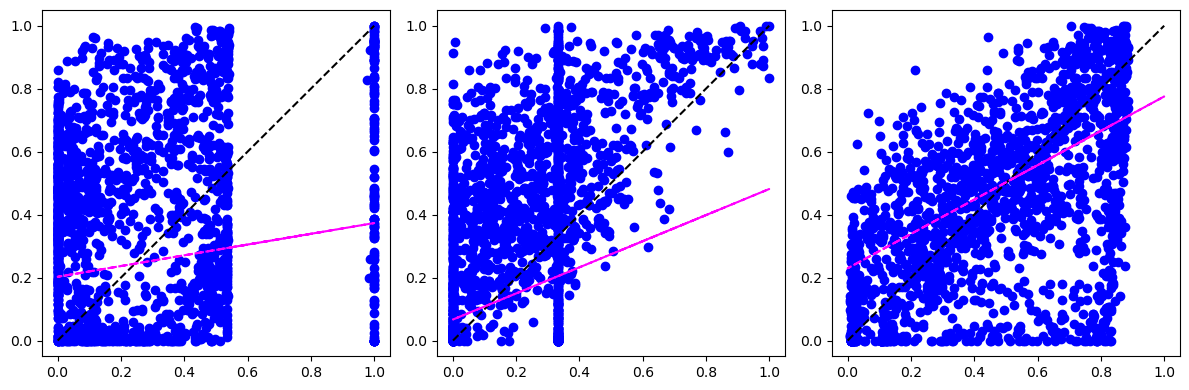

Best fit line for soil_fraction: slope = 0.22317376430112348, intercept = 0.16057533063550805, r^2 = 0.04635936976963662
Best fit line for soil_fraction: slope = 0.3787624684809089, intercept = 0.23831442922847765, r^2 = 0.08844381115607393
Best fit line for soil_fraction: slope = 0.482732602209165, intercept = 0.13307013503775156, r^2 = 0.27385309774182803


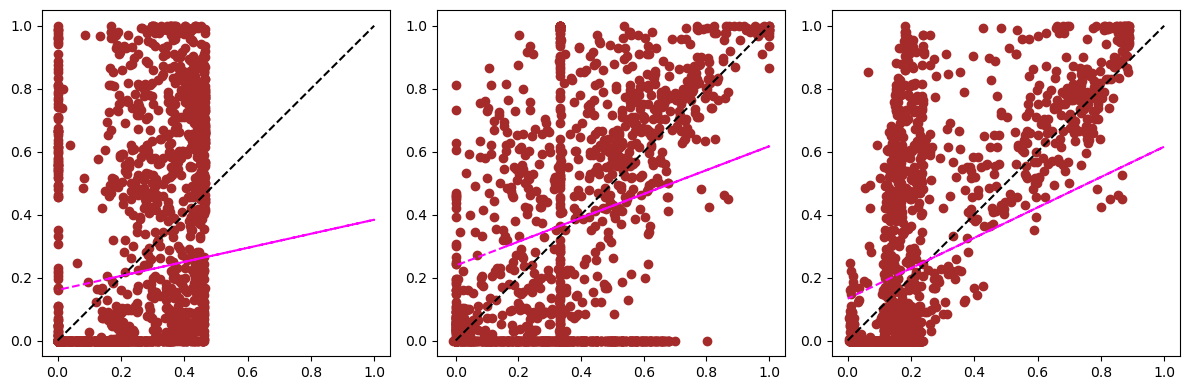

Best fit line for gv_fraction: slope = 0.9281607763256623, intercept = 0.2196166533521065, r^2 = 0.3400057446484414
Best fit line for gv_fraction: slope = 0.4371144798669171, intercept = 0.2875563452181559, r^2 = 0.05467810949946796
Best fit line for gv_fraction: slope = 0.9428604396870511, intercept = -0.014451353095659092, r^2 = 0.537148672156444


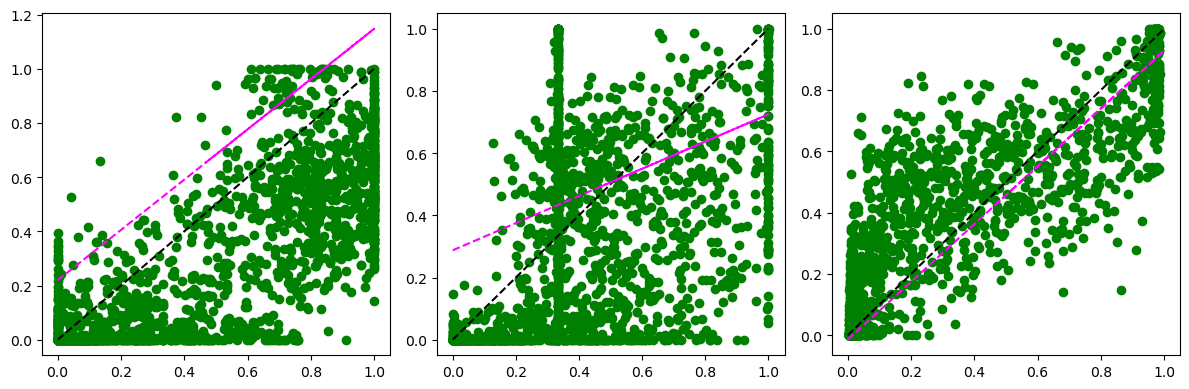

Best fit line for npv_fraction: slope = 0.17447046309579683, intercept = 0.201106176375702, r^2 = 0.0009470059984151155
Best fit line for npv_fraction: slope = 0.4110789373268286, intercept = 0.06632355787644253, r^2 = 0.09055844476907098
Best fit line for npv_fraction: slope = 0.5459899348346052, intercept = 0.22977605807166343, r^2 = 0.09613897629782324


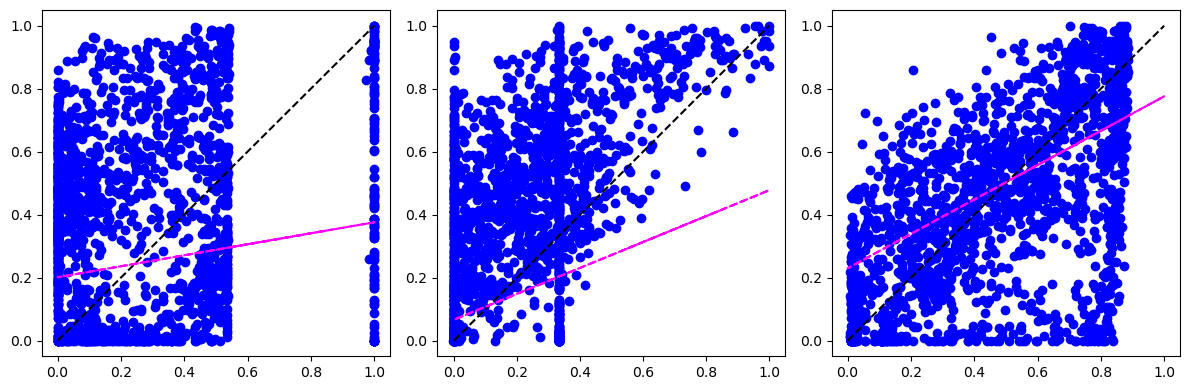

Best fit line for soil_fraction: slope = 0.22521015492538787, intercept = 0.1597916280281688, r^2 = 0.04809558340026814
Best fit line for soil_fraction: slope = 0.36803327868387625, intercept = 0.23806093905964243, r^2 = 0.08566785094101945
Best fit line for soil_fraction: slope = 0.4820554928424016, intercept = 0.1329068790202863, r^2 = 0.2727997909621728


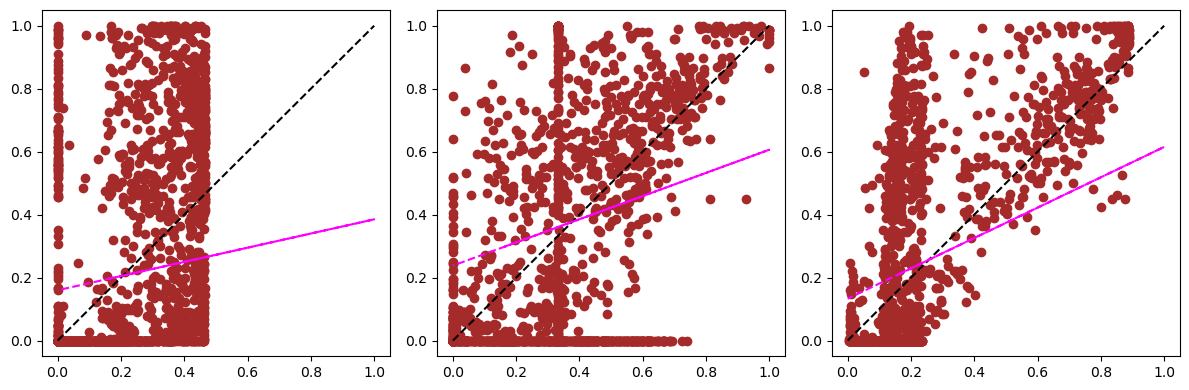

Best fit line for gv_fraction: slope = 0.9280068783089919, intercept = 0.21967352548729413, r^2 = 0.33993135664908114
Best fit line for gv_fraction: slope = 0.41610581408339253, intercept = 0.284676339619339, r^2 = 0.047467278977323564
Best fit line for gv_fraction: slope = 0.9444689464114637, intercept = -0.01477094721088229, r^2 = 0.5390410289869823


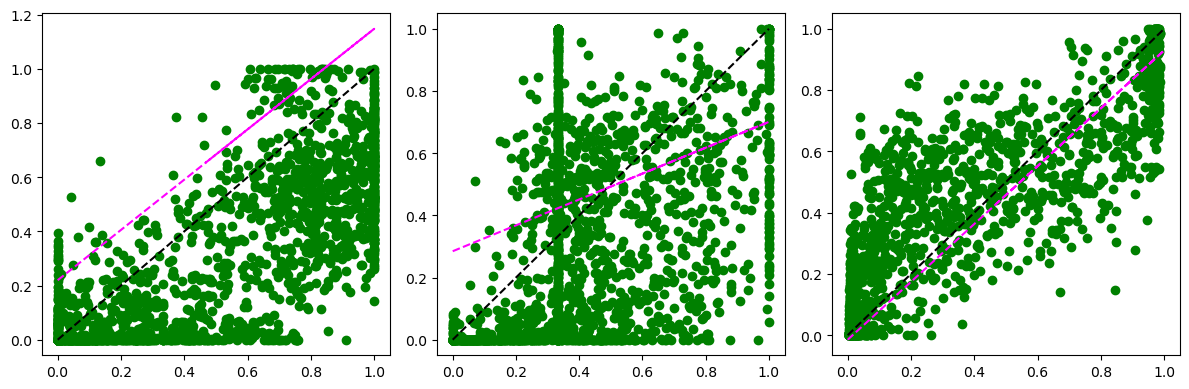

Best fit line for npv_fraction: slope = 0.174463320591602, intercept = 0.20109389058568528, r^2 = 0.000947243588926262
Best fit line for npv_fraction: slope = 0.41325939542210754, intercept = 0.06791686400511998, r^2 = 0.09398918608732271
Best fit line for npv_fraction: slope = 0.5465288416380057, intercept = 0.2290412030130579, r^2 = 0.0962992314368988


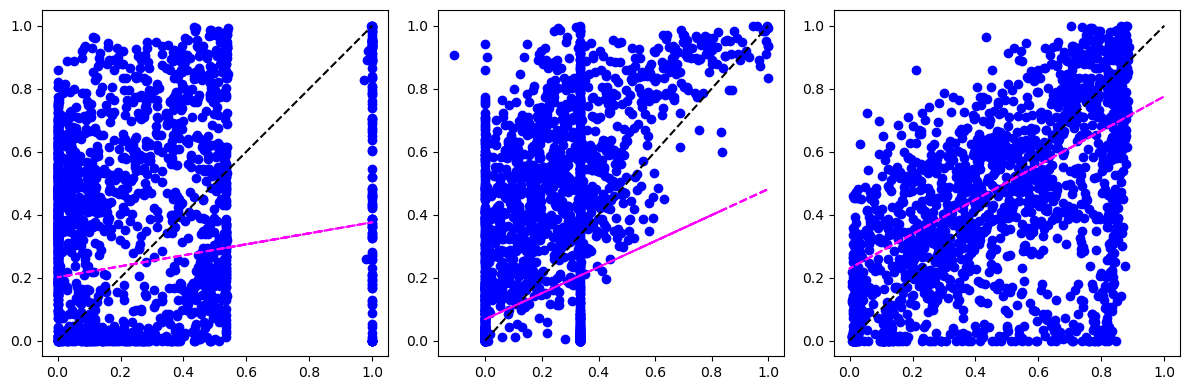

Best fit line for soil_fraction: slope = 0.22517609757817694, intercept = 0.15980625970838375, r^2 = 0.04809527348713313
Best fit line for soil_fraction: slope = 0.3961916671969627, intercept = 0.23764544349102834, r^2 = 0.10504163646385858
Best fit line for soil_fraction: slope = 0.4836281657414753, intercept = 0.13282814069453894, r^2 = 0.2735225851455644


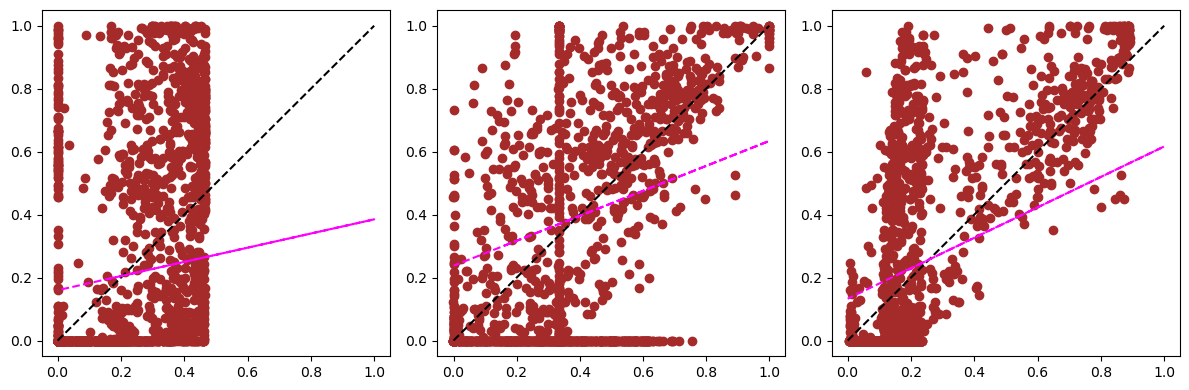

In [158]:
"""
We also generate a database to export as csv for further analysis on R^2, P-value, and Standard Error.

The columns are R^2 value, P-value, Standard Error
Rows are different SNR

Each entry is a list of lists, where first list is the values obtained by RMSE/Derivative/KLDiv on GV, second list is the values obtained by RMSE/Derivative/KLDiv on NPV, and third list is the values obtained by RMSE/Derivative/KLDiv on Soil.
"""

Results = pd.DataFrame(columns=['SNR', 'R^2', 'P-value', 'Standard Error', 'Slope', 'Intercept'])
Results.astype('object')

list_R2 = [[], [], []]
list_P = [[], [], []]
list_SE = [[], [], []]
list_Slope = [[], [], []]
list_Intercept = [[], [], []]

for i in range(len(SNR_options)):
    Results.loc[SNR_options[i], 'SNR'] = SNR_options[i]
    Results.loc[SNR_options[i], 'R^2'] = [[], [], []]
    Results.loc[SNR_options[i], 'P-value'] = [[], [], []]
    Results.loc[SNR_options[i], 'Standard Error'] = [[], [], []]
    Results.loc[SNR_options[i], 'Slope'] = [[], [], []]
    Results.loc[SNR_options[i], 'Intercept'] = [[], [], []]

Results.to_csv(r"C:\SenkDosya\UTAT\Github\FINCH-Science\Scientific_Requirements\SNR_In_Unmixing\SNR_Results.csv", index=False)



for i in SNR_options:
    #fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    #plot3_abundance_comparison(ax[0], pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=False)
    #plot3_abundance_comparison(ax[1], pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=False)
    #plot3_abundance_comparison(ax[2], pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=False)
    #plt.tight_layout()
    #plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plot3_single_abundance_comparison(ax[0], 0, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plot3_single_abundance_comparison(ax[1], 0, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plot3_single_abundance_comparison(ax[2], 0, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plot3_single_abundance_comparison(ax[0], 1, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plot3_single_abundance_comparison(ax[1], 1, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plot3_single_abundance_comparison(ax[2], 1, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    plot3_single_abundance_comparison(ax[0], 2, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_RMSE_SNR_{i}']), title=f"RMSE Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plot3_single_abundance_comparison(ax[1], 2, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_Derivative_SNR_{i}']), title=f"Derivative Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plot3_single_abundance_comparison(ax[2], 2, pd.DataFrame(globals()[f'abundances_library_SNR_{i}']), pd.DataFrame(globals()[f'abundances_KLDiv_SNR_{i}']), title=f"KL Divergence Abundance Comparison SNR {i}", goalline=True, best_fit=True)
    plt.tight_layout()
    plt.show()